# Imputation

With initialized data in dataframe, there are still 1.46\% of missing data. Therefore, we need to impute these value to proceed our analysis. 

In [1]:
import numpy as np
import pandas as pd
import math
import os
import pickle
import copy
import itertools
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from tqdm.notebook import tqdm
from sklearn.preprocessing import scale

from scipy.spatial import distance

In [2]:
# loading original and standardised data set
dict_all = pickle.load(open('C:\\Users\\ALIENWARE\\Desktop\\Utils\\dict.pkl', 'rb'))
dict_all_std = pickle.load(open('C:\\Users\\ALIENWARE\\Desktop\\Utils\\dict_std.pkl', 'rb'))

In [3]:
# check
print('Original values: ')
print(dict_all['Darlington'].loc['Economic activity rate - aged 16-64'])

print('--------')

print('Standardised values: ')
print(dict_all_std['Darlington'].loc['Economic activity rate - aged 16-64'])

Original values: 
year
2004    76.2
2005    75.6
2006    76.3
2007    76.7
2008    76.4
2009    74.6
2010    76.1
2011    74.4
2012    77.0
2013    79.3
2014    78.1
2015    77.6
2016    79.6
2017    79.4
2018    79.1
2019    79.4
2020    78.8
Name: Economic activity rate - aged 16-64, dtype: object
--------
Standardised values: 
year
2004   -0.673431
2005   -1.031192
2006   -0.613805
2007   -0.375298
2008   -0.554178
2009   -1.627459
2010   -0.733058
2011   -1.746713
2012   -0.196417
2013    1.174997
2014    0.459477
2015    0.161343
2016    1.353878
2017    1.234624
2018    1.055744
2019    1.234624
2020    0.876864
Name: Economic activity rate - aged 16-64, dtype: object


count total number of value

In [4]:
# number of values
s = 0
for country in dict_all_std.keys():
    s += np.sum(dict_all_std[country].count())

print(s)

181836


In [5]:
dict_all_std['Darlington']

year,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
Economic activity rate - aged 16-64,-0.673431,-1.031192,-0.613805,-0.375298,-0.554178,-1.627459,-0.733058,-1.746713,-0.196417,1.174997,0.459477,0.161343,1.353878,1.234624,1.055744,1.234624,0.876864
Employment rate - aged 16-64,0.809433,0.185986,0.49771,-0.214801,-0.125737,-1.728886,-0.704652,-2.04061,-1.728886,0.230518,-0.214801,0.05239,1.076625,0.898497,1.43288,0.809433,0.764901
% aged 16-64 who are employees,1.005707,0.226884,0.783186,0.338144,0.04145,-1.738716,-0.922807,-1.330762,-2.035411,-0.366505,-0.255244,-0.181071,0.226884,1.339488,1.376575,0.338144,1.154054
% aged 16-64 who are self employed,-0.99244,-0.198488,-1.091684,-1.190927,-0.297732,0.893196,1.190927,-0.99244,1.488659,1.290171,-0.198488,0.396976,1.290171,-1.389415,0.0,0.99244,-1.190927
Unemployment rate - aged 16-64,-1.829,-1.333889,-1.333889,-0.09611,-0.393177,0.894113,0.250468,1.240691,2.280426,0.795091,0.795091,0.101935,-0.195132,-0.046599,-0.987311,0.052424,-0.195132
Unemployment rate - aged 16+,-1.897667,-1.285129,-1.336174,-0.060053,-0.264232,0.909799,0.246216,1.267113,2.236965,0.858754,0.807709,0.042037,-0.315277,-0.111098,-0.927815,-0.009008,-0.162142
% who are economically inactive - aged 16-64,0.673431,1.031192,0.613805,0.375298,0.554178,1.627459,0.733058,1.746713,0.196417,-1.174997,-0.459477,-0.161343,-1.353878,-1.234624,-1.055744,-1.234624,-0.876864
% of economically inactive who want a job,-0.519445,-0.13772,0.523936,0.447591,0.676625,0.218556,-1.384687,-0.697583,0.294901,-0.672135,0.625729,-0.188617,0.549384,-1.893653,-1.359239,1.287385,2.228972
% of economically inactive who do not want a job,0.519445,0.13772,-0.523936,-0.447591,-0.676625,-0.218556,1.384687,0.697583,-0.294901,0.672135,-0.625729,0.188617,-0.549384,1.893653,1.359239,-1.287385,-2.228972
Economic activity rate males - aged 16-64,0.687301,-0.374892,-1.08302,0.451258,-0.138849,-0.138849,-1.201041,-1.673127,0.451258,0.687301,1.39543,-0.964999,0.687301,2.103558,-1.319063,0.687301,-0.25687


## Calculating Euclidean Distance

In [6]:
#loading authorityname and dataset
EMPLOYMENT = pd.read_csv("EMPLOYMENT.csv",dtype = "object",na_values=["*","-","!"],skiprows=6)

Employmentall = EMPLOYMENT.dropna(subset=["row"])
a = ['row']
Employmentall = Employmentall[~Employmentall['row'].isin(a)]
Employmentall['year']=0
for i in range(17):
    Employmentall['year'][i*206:(i+1)*206] = 2004+i

#recall authorityname 
authoritynames = list(Employmentall['local authority: county / unitary (as of April 2021)'].unique())


Initialize variables and all combinations of authorities:

In [7]:
# first create list out of all unique combinations
authoritycombs = list(itertools.combinations(authoritynames, 2))
authoritycombs

[('Darlington', 'County Durham'),
 ('Darlington', 'Hartlepool'),
 ('Darlington', 'Middlesbrough'),
 ('Darlington', 'Northumberland'),
 ('Darlington', 'Redcar and Cleveland'),
 ('Darlington', 'Stockton-on-Tees'),
 ('Darlington', 'Gateshead'),
 ('Darlington', 'Newcastle upon Tyne'),
 ('Darlington', 'North Tyneside'),
 ('Darlington', 'South Tyneside'),
 ('Darlington', 'Sunderland'),
 ('Darlington', 'Blackburn with Darwen'),
 ('Darlington', 'Blackpool'),
 ('Darlington', 'Cheshire East'),
 ('Darlington', 'Cheshire West and Chester'),
 ('Darlington', 'Halton'),
 ('Darlington', 'Warrington'),
 ('Darlington', 'Cumbria'),
 ('Darlington', 'Bolton'),
 ('Darlington', 'Bury'),
 ('Darlington', 'Manchester'),
 ('Darlington', 'Oldham'),
 ('Darlington', 'Rochdale'),
 ('Darlington', 'Salford'),
 ('Darlington', 'Stockport'),
 ('Darlington', 'Tameside'),
 ('Darlington', 'Trafford'),
 ('Darlington', 'Wigan'),
 ('Darlington', 'Lancashire'),
 ('Darlington', 'Knowsley'),
 ('Darlington', 'Liverpool'),
 ('Darli

In [8]:
#define the length of chosen period
period = range(2004,2021)

In [9]:
# call variablename

variablenames = list(dict_all['Darlington'].index)
print(len(variablenames))

54


## Comparing Euclidean distances computed with vectors of different dimensions

Calculate euclidean distances for imputation purposes and store in the dict_e dictionary.

In [10]:

dict_e = {}    

for year in period:
    print(year)
    
    for authoritycomb in authoritycombs:
        
        country0_e = []    # create two empty lists for the two groupings we consider at the moment
        country1_e = []    # these lists contain series codes with data available in both groupings
        j = 0    # counter
        
        for variablename in variablenames[:-2]:
            # we can only consider sub-indicators with data available in both groupings
            if pd.isna(dict_all_std[authoritycomb[0]].loc[variablename, year]) is False and pd.isna(dict_all_std[authoritycomb[1]].loc[variablename, year]) is False:
                country0_e.append(dict_all_std[authoritycomb[0]].loc[variablename, year])
                country1_e.append(dict_all_std[authoritycomb[1]].loc[variablename, year])
                
                j += 1
        
        #print('number of data points available: ', j)    # check
        if j > 0:
            e = distance.euclidean(country0_e, country1_e, w=1/j)
        else:
            e = np.nan    # make NaN
            
        #print('e in {} between {} and {}:'.format(year, countrycombination[0], countrycombination[1]), e)
        
        dict_e[year, authoritycomb[1], authoritycomb[0]] = e
        dict_e[year, authoritycomb[0], authoritycomb[1]] = dict_e[year, authoritycomb[1], authoritycomb[0]]


2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020


In [11]:
# Save data for storage
#check if the direction exist
import os
filename = "C:\\Users\\ALIENWARE\\Desktop\\Utils\\distances_unstd.pkl"
os.makedirs(os.path.dirname(filename), exist_ok=True)
f = open('C:\\Users\\ALIENWARE\\Desktop\\Utils\\distances_unstd.pkl', 'wb')
pickle.dump(dict_e, f)
f.close()

In [12]:
# CHECKPOINT
dict_e = pickle.load(open('C:\\Users\\ALIENWARE\\Desktop\\Utils\\distances_unstd.pkl', 'rb'))

In [13]:

# check
print(dict_e[2004, 'Darlington', 'Bury'])

1.145699458785633


## Normalization of Euclidean distances
With the dictionary dict_e, we normalized these euclidean distances to get a normalized value.

In [14]:
dict_normalized = {}

for year in period:
    print(year)
    
    max_e = 0    # maximum value per year
    min_e = 0
    dict_e_year = {}    # auxiliary dictionary with all distances per year
    
    for k in dict_e.keys():
        if year in k:
            dict_e_year[k] = dict_e[k]    
            
    #Return the maximum of an array or maximum along an axis, ignoring any NaNs
    max_e = np.nanmax(list(dict_e_year.values()))
       
    for k in dict_e_year.keys():
        #now consider nan case and not nan case seperately
        if np.isnan(dict_e_year[k]) == False:
            
            dict_normalized[k] = dict_e_year[k] / max_e    # standardise distance
            
        else:
            dict_normalized[k] = np.nan    # keep as NaN
        

2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020


In [15]:
dict_normalized
dict_all_std['Swansea']

year,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
Economic activity rate - aged 16-64,1.422243,0.044445,0.222225,0.577786,-0.133335,-0.311116,-2.35559,-1.111127,-0.977792,-0.355561,0.933347,1.066682,0.755567,-1.066682,-0.533341,0.222225,1.600023
Employment rate - aged 16-64,1.22409,0.595614,0.525784,0.840022,-0.486761,-0.870829,-2.092866,-1.429475,-1.185067,-0.835914,0.455953,0.386122,0.70036,-0.137607,-0.277269,0.874937,1.712905
% aged 16-64 who are employees,1.884991,0.85814,0.716505,0.716505,0.114557,-0.735251,-1.939146,-1.408016,-1.124746,-0.947703,0.149966,0.079149,0.504053,-0.416573,-0.451981,0.468644,1.530905
% aged 16-64 who are self employed,-1.988856,-1.342795,-0.481379,0.272359,-1.558148,-0.696733,-0.373702,-0.266025,-0.481379,0.057005,0.810744,1.133775,0.487713,0.810744,0.810744,1.672159,1.133775
Unemployment rate - aged 16-64,-0.406906,-1.157631,-0.782268,-0.835891,0.772805,1.309038,0.826429,1.416284,0.987298,1.255414,0.504689,0.772805,-0.299659,-1.425747,-0.299659,-1.532993,-1.104008
Unemployment rate - aged 16+,-0.420049,-1.201079,-0.698988,-0.866352,0.751495,1.309373,0.86307,1.476736,1.030434,1.197797,0.472556,0.751495,-0.308474,-1.256866,-0.364262,-1.591593,-1.145291
% who are economically inactive - aged 16-64,-1.422243,-0.044445,-0.222225,-0.577786,0.133335,0.311116,2.35559,1.111127,0.977792,0.355561,-0.933347,-1.066682,-0.755567,1.066682,0.533341,-0.222225,-1.600023
% of economically inactive who want a job,0.934613,-1.330333,0.765588,-0.85706,-1.093697,1.576912,0.292315,0.123289,-0.282373,-0.451398,1.914963,0.900808,0.867003,-0.316178,-0.417593,-1.397943,-1.228917
% of economically inactive who do not want a job,-0.934613,1.330333,-0.765588,0.85706,1.093697,-1.576912,-0.292315,-0.123289,0.282373,0.451398,-1.914963,-0.900808,-0.867003,0.316178,0.417593,1.397943,1.228917
Economic activity rate males - aged 16-64,1.175713,0.316454,0.690045,1.250432,0.017581,0.577968,-1.588861,-0.841679,-1.103193,-1.103193,0.839481,1.100995,-0.019778,-2.261325,0.092299,0.615327,0.241735


In [16]:
# check
print('unstandardised distance:', dict_e[2016, 'Darlington', 'Bury'])
print('normalised distance: ', dict_normalized[2016, 'Darlington', 'Bury'])


unstandardised distance: 1.0711236193502227
normalised distance:  0.4133415334735063


In [17]:
dict_normalized[(2011, 'City of London', 'Sutton')]
len(authoritynames)


206

With normalized data, we want to store them into a dictionary so it is more convenient to call. 

In [18]:
#include the data into dictionary
dict_all_i = {}

for authority in (authoritynames):
    
    dict_all_i[authority] = pd.DataFrame(index=variablenames, columns=period)
    
    alternative_authorities = [c for c in authoritynames if c != authority]
    
    for variablename in variablenames[:-2]:
        for year in period:            
            if pd.isna(dict_all_std[authority].loc[variablename, year]) is True:
                K = 0
                all_k = []
                
                for alternative_authority in alternative_authorities: 
                    #make sure that other than the chosen authority, take the distance with the other corresponding authority
                    if pd.isna(dict_all_std[alternative_authority].loc[variablename, year]) is False and pd.isna(dict_normalized[(year, authority, alternative_authority)]) is False: 
                        K += 1
                        
                        k = (dict_all_std[alternative_authority].loc[variablename, year]) / (dict_normalized[(year, authority, alternative_authority)])
                        # print('k =', k)
                        all_k.append(k)
                        # print('K =', K)
                        
                sum_k = np.sum(all_k)
                    
                    
                if K > 0:
                    dict_all_i[authority].loc[variablename, year] = sum_k / K
                            
                else:
                    dict_all_i[authority].loc[variablename, year] = np.nan    # only impute when data of other countries is available, 0 cannot be imputed because time-series are non-stationary
                
                #print('Imputation for {} in {} in {}'.format(seriescode, country, year), dict_all_i[country].loc[seriescode, year])        
                
            else:
                dict_all_i[authority].loc[variablename, year] = dict_all_std[authority].loc[variablename, year]
    

In [19]:
# check
print('NaN here',dict_all_std['City of London'].loc['Employment rate - aged 16-64',2011])
print('Imputed value', dict_all_i['City of London'].loc['Employment rate - aged 16-64',2011])



NaN here nan
Imputed value -3.536340728952305


In [20]:
# as csv files
if not os.path.exists('csv_imputed'):
    os.mkdir('csv_imputed')

for c in authoritynames:
    dict_all_i[c].to_csv(r'csv_imputed/{}_wb.csv'.format(c))
    
# as pkl files
imp = open('C:\\Users\\ALIENWARE\\Desktop\\Utils\\dict_all_i_wb.pkl', 'wb')
pickle.dump(dict_all_i, imp)
imp.close()

In [21]:
# number of values
s_imp = 0
for country in dict_all_i.keys():
    s_imp += np.sum(dict_all_i[country].count())


print('How many have been imputed?', abs(s_imp - s))
print('This accounts for', round(100*(s_imp-s)/s, 2), '% of the total data available now')

How many have been imputed? 2204
This accounts for -1.21 % of the total data available now


# Store in variables

In [22]:
info=dict_all_std['Darlington'].index
info

Index(['Economic activity rate - aged 16-64', 'Employment rate - aged 16-64',
       '% aged 16-64 who are employees', '% aged 16-64 who are self employed',
       'Unemployment rate - aged 16-64', 'Unemployment rate - aged 16+',
       '% who are economically inactive - aged 16-64',
       '% of economically inactive who want a job',
       '% of economically inactive who do not want a job',
       'Economic activity rate males - aged 16-64',
       'Employment rate males - aged 16-64',
       '% of males aged 16-64 who are employees',
       '% of males aged 16-64 who are self employed',
       'Unemployment rate males - aged 16-64',
       'Unemployment rate males - aged 16+',
       '% of  males who are economically inactive - aged 16-64',
       '% of economically inactive males who want a job',
       '% of economically inactive males who do not want a job',
       'Economic activity rate females - aged 16-64',
       'Employment rate females - aged 16-64',
       '% of females a

In [23]:
#goals = list(info.unique())

#dict_goals = {}

#for goal in goals:
#    dict_goals[goal] = list(set(dict_goals[goal]))

## Visualising time-series after imputation

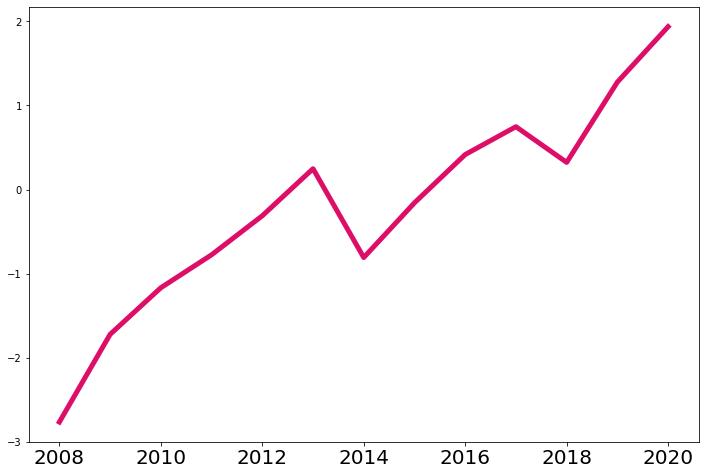

In [24]:
plt.figure(figsize=(12,8))
plt.plot(list(range(2008, 2021)), dict_all_i['Stockton-on-Tees'].loc['earnings'][4:], color='#DE0E68', linewidth=5)
plt.xticks(np.arange(2008, 2021, step=2), size=20)
plt.show()

# Visualization for different years relation for unemployment and earnings

In [25]:
#define a function that can generate unemployment and earnings for respective year of dataset.
def unemployearnings(years):
    #initialize an empty vector with the first column unemployment and earnings
    unemployment_earning_val = np.zeros([len(authoritynames),2])
    for i in range(len(authoritynames)):
        #store unemployment rate
        unemployment_earning_val[i,0] = dict_all_i[authoritynames[i]].iloc[4,years]
        #store earnings
        unemployment_earning_val[i,1] = dict_all_i[authoritynames[i]].iloc[-6,years]
    return unemployment_earning_val


unemployearnings(4)

array([[-0.39317683, -1.54612666],
       [-0.07446481, -1.48287255],
       [-0.17654141, -1.42642135],
       [-0.26798865, -1.33160102],
       [-0.2944995 , -1.53815466],
       [ 0.18701575, -1.81147381],
       [ 0.40765843, -2.76638352],
       [-0.03360868, -1.82484928],
       [ 0.30703978, -0.99546967],
       [-0.01117467, -1.18657747],
       [-1.17488728, -2.51474122],
       [ 0.02558809, -1.86240294],
       [-0.11368791, -0.67055717],
       [-1.2063715 , -3.26031501],
       [-0.00403613, -0.46237095],
       [ 0.73323535, -1.14068784],
       [-0.01092036, -1.54359044],
       [ 0.65742509, -0.42528773],
       [-1.0790507 , -1.0211656 ],
       [ 0.58835429, -1.12364824],
       [-0.56520185, -1.0019987 ],
       [ 0.57410725, -1.46204753],
       [ 0.83282332, -0.01550244],
       [-0.03015132,  0.76318309],
       [ 0.04344091, -0.85733395],
       [ 0.29140485, -1.27566076],
       [ 0.24576562, -0.63787356],
       [ 0.08893909, -1.21574825],
       [-0.34749197,

Year 2008 has result:


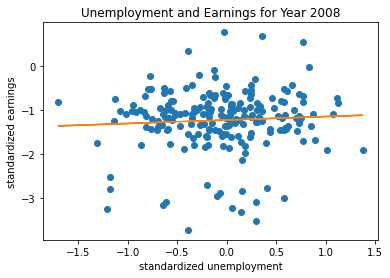

Year 2009 has result:


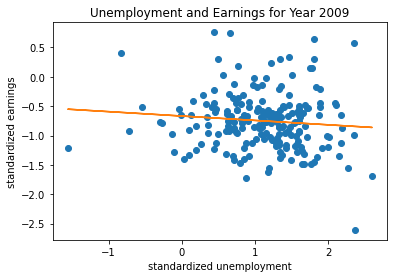

Year 2010 has result:


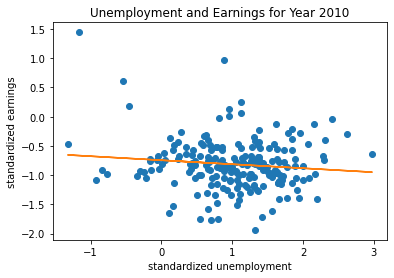

Year 2011 has result:


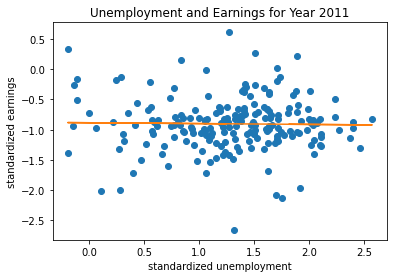

Year 2012 has result:


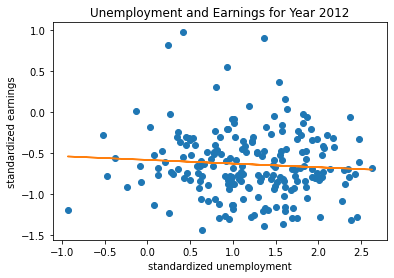

Year 2013 has result:


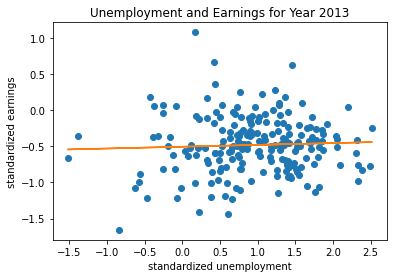

Year 2014 has result:


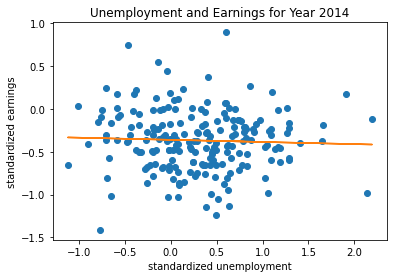

Year 2015 has result:


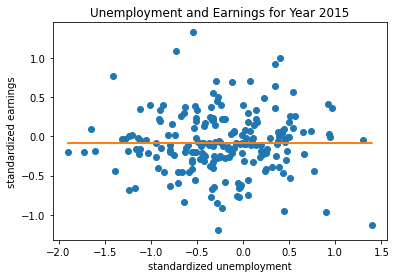

Year 2016 has result:


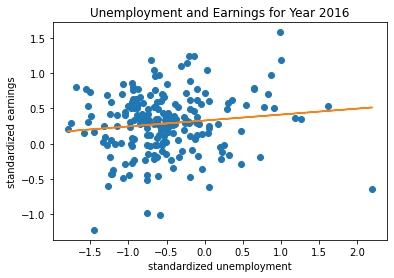

Year 2017 has result:


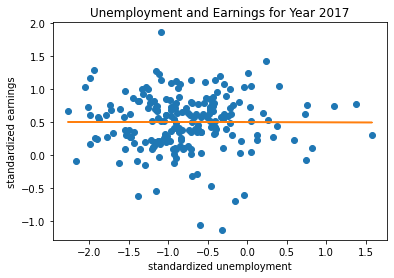

Year 2018 has result:


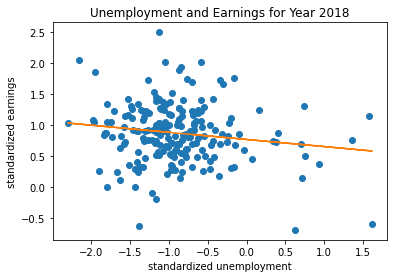

Year 2019 has result:


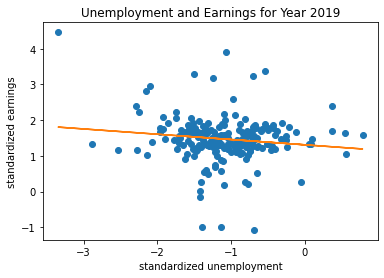

Year 2020 has result:


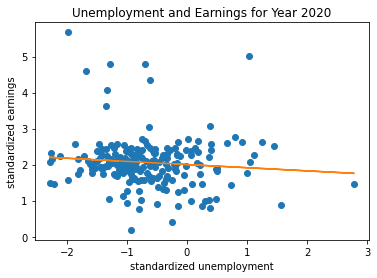

In [26]:
for i in range(4,17):
    plotvec = unemployearnings(i)
    plotvec = plotvec[plotvec[:,0]<3]
    print(f'Year {2004+i} has result:')
    #fit the value with a linear line:
    m, b = np.polyfit(plotvec[:,0], plotvec[:,1], 1)
    # plot with various axes scales
    plt.figure()
    plt.plot(plotvec[:,0], plotvec[:,1],'o')
    plt.plot(plotvec[:,0], m*plotvec[:,0] + b)
    plt.xlabel('standardized unemployment')
    plt.ylabel('standardized earnings')
    plt.title(f'Unemployment and Earnings for Year {2004+i}')
    plt.show()
